In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
orion_members = pd.read_csv('./data/OrionMembers.csv', encoding = 'utf8')

# Convert to degrees:
ra_deg = Angle([hms for hms in orion_members.RA], unit="hour")
dec_deg = Angle([d[0:3]+'d'+d[5:7]+'m'+d[9:-1]+'s' for d in orion_members.Dec], unit='degree')

orion_members['RA_deg'] = ra_deg.to_value(u.degree)
orion_members['Dec_deg'] = dec_deg.to_value(u.degree)

dist_pc = (np.array(orion_members.Dist_ly)*u.lightyear).to_value(u.pc)
orion_members['Dist_pc'] = dist_pc


In [4]:
orion_members[['RA','RA_deg','Dec','Dec_deg']]

,RA,RA_deg,Dec,Dec_deg
0,05h 14m 32.27s,78.634458,−08° 12′ 05.9″,-8.201639
1,05h 55m 10.29s,88.792875,+07° 24′ 25.3″,7.407028
2,05h 25m 07.87s,81.282792,+06° 20′ 59.0″,6.349722
3,05h 36m 12.81s,84.053375,−01° 12′ 06.9″,-1.201917
4,05h 40m 45.52s,85.189667,−01° 56′ 33.3″,-1.942583
...,...,...,...,...
299,05h 35m 26.97s,83.862375,−05° 09′ 54.5″,-5.165139
300,05h 35m 14.51s,83.810458,−05° 22′ 30.4″,-5.375111
301,05h 40m 27.45s,85.114375,−07° 27′ 30.1″,-7.458361
302,05h 38m 10.10s,84.542083,−02° 26′ 26.0″,-2.440556


In [5]:
#from SIMBAD, NGC 1909
witchhead = (Angle("05h 02m 00.00s", unit=u.hour).to_value(u.degree),
              Angle("−07d54m00s", unit=u.degree).to_value(u.degree))

In [6]:
witchhead

(75.49999999999999, -7.9)

In [7]:
#from Gaia source id search
orion_runaways_gaiaedr3ids = {
    'MuColumbae':2901155648586891648,
    'AeAuriga':182071570715713024
}
id_list = [orion_runaways_gaiaedr3ids[ra] for ra in orion_runaways_gaiaedr3ids]
orion_runaways = gs(name = 'Orion Runaways')
orion_runaways.from_source_idlist(id_list)

#stuff in radial velocities from SIMBAD, Gaia doesn't have these
orion_runaways.objs['radial_velocity'] = [109.00, 56.70]

INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
#ONC mmotions frmo Farias et al 2020
ONC = pd.Series({'ra':Angle('05h35m0.0s', unit=u.hour).to_value(u.degree),
                    'dec':Angle('-05d29m0.0s', unit=u.degree).to_value(u.degree), 'parallax': 2.48, 'r_est':403,
                    'pmra':1.43, 'pmra_error':0.14, 'pmdec':0.52, 'pmdec_error':0.12,
                    'radial_velocity':26.4, 'radial_velocity_error':1.6})

In [9]:
ONC

ra                        83.750000
dec                       -5.483333
parallax                   2.480000
r_est                    403.000000
pmra                       1.430000
pmra_error                 0.140000
pmdec                      0.520000
pmdec_error                0.120000
radial_velocity           26.400000
radial_velocity_error      1.600000
dtype: float64

In [10]:
#plt.style.use('dark_background')

plt.style.use('default')
from matplotlib.patches import Circle

## Cone Search Parameters

In [11]:
cone_search_center=(77.0, -8.0); search_radius=7.5 #degree
#Kun et al (2001) distance: 210 pc +/- 20pc
#keep distance between 100 and 300 pc
dist_constraint=(100,300) #pc
plx_hi = 1000.0/dist_constraint[0]
plx_lo = 1000.0/dist_constraint[1]
(plx_lo, plx_hi)

(3.3333333333333335, 10.0)

Text(0, 0.5, 'Declination')

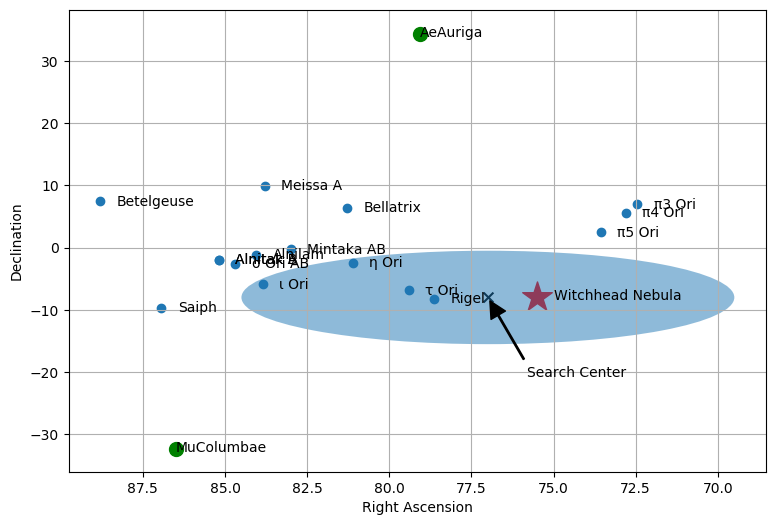

In [12]:
orion_bright = orion_members.query('AppMag <= 4')
offset=-0.5
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()

circ = Circle(cone_search_center, search_radius, alpha=0.5)
ax.add_patch(circ)

ax.scatter(orion_bright.RA_deg, orion_bright.Dec_deg)
for s in orion_bright.itertuples():
    ax.annotate(s.Name,(s.RA_deg, s.Dec_deg),ha='left', va='center', xytext=((s.RA_deg+offset, s.Dec_deg)))
    
ax.scatter(witchhead[0], witchhead[1], s=500,color='red', marker='*')
ax.annotate('Witchhead Nebula', (witchhead[0]+offset, witchhead[1]+offset))

ax.scatter(cone_search_center[0], cone_search_center[1], marker='x',s=50, color='black')
ax.annotate('Search Center',(cone_search_center[0], cone_search_center[1]),
            xytext=(0.8, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            horizontalalignment='right', verticalalignment='top',va='bottom')

for ora in orion_runaways_gaiaedr3ids:
    s = orion_runaways.objs.loc[orion_runaways_gaiaedr3ids[ora]]
    ax.scatter(s.ra, s.dec, s=100, color='green')
    ax.annotate(ora,(s.ra, s.dec+offset))

ax.invert_xaxis()
ax.grid()
#ax.set_aspect('equal')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

## Cone Search

In [15]:
search_results1=gs(name="conesearch near witch head nebula")
search_results1.conesearch(cone_search_center[0]*u.degree, cone_search_center[1]*u.degree,search_radius*u.degree, parallax=(plx_lo, plx_hi))
len(search_results1)

INFO: Query finished. [astroquery.utils.tap.core]


16218

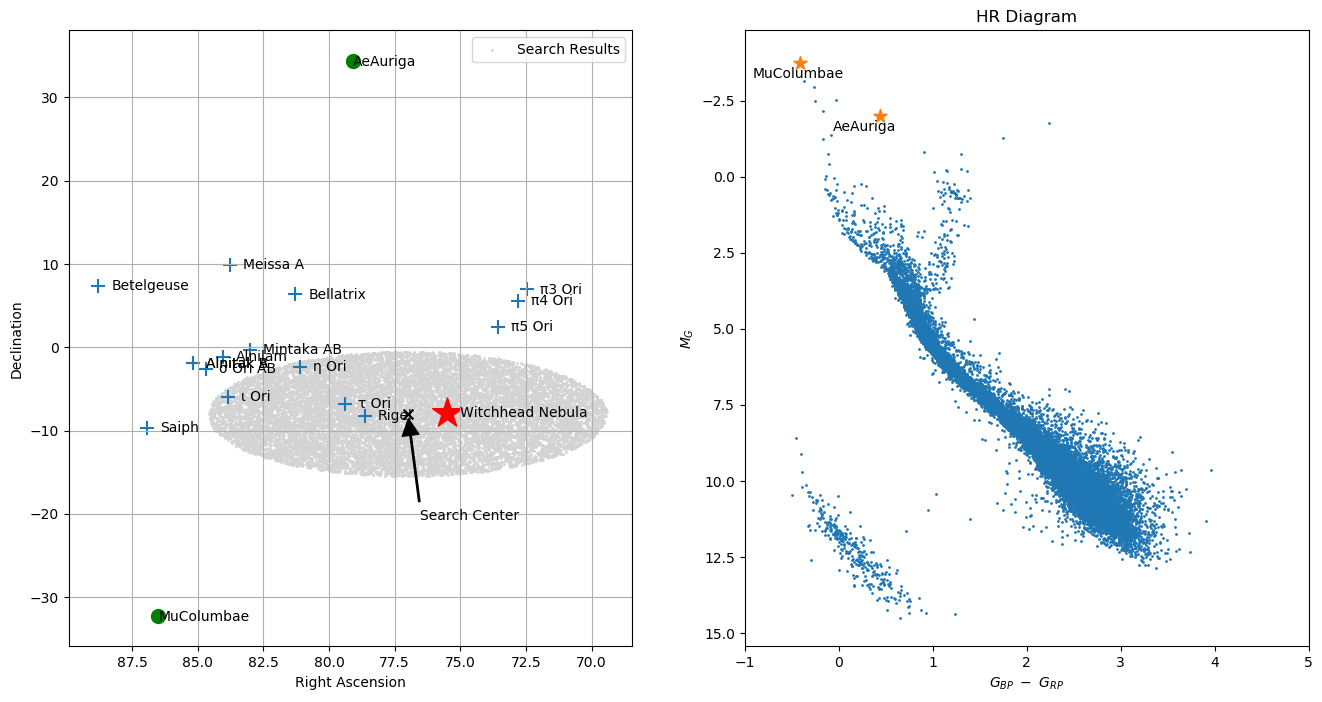

In [17]:

fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
ax=axs[0]

ax.scatter(search_results1.objs.ra, search_results1.objs.dec, s=1, label='Search Results', color='lightgrey')

ax.scatter(orion_bright.RA_deg, orion_bright.Dec_deg,s=100, marker='+')
for s in orion_bright.itertuples():
    ax.annotate(s.Name,(s.RA_deg+offset, s.Dec_deg+offset))
for ora in orion_runaways_gaiaedr3ids:
    s = orion_runaways.objs.loc[orion_runaways_gaiaedr3ids[ora]]
    ax.scatter(s.ra, s.dec, s=100, color='green')
    ax.annotate(ora,(s.ra, s.dec+offset))
    
ax.scatter(witchhead[0], witchhead[1], s=500,color='red', marker='*')
ax.annotate('Witchhead Nebula', (witchhead[0]+offset, witchhead[1]+offset))

ax.scatter(cone_search_center[0], cone_search_center[1], marker='x',s=50, color='black')
ax.annotate('Search Center',(cone_search_center[0], cone_search_center[1]),
            xytext=(0.8, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            horizontalalignment='right', verticalalignment='top',va='bottom')



ax.invert_xaxis()
ax.grid(); ax.legend()
#ax.set_aspect('equal')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

search_results1.plot_hrdiagram(ax=axs[1])
orion_runaways.plot_hrdiagram(ax=axs[1], s=100, marker='*')
BP_RP, M_G=orion_runaways.get_colors()
for ora in orion_runaways_gaiaedr3ids:
    axs[1].annotate(ora, (BP_RP.loc[orion_runaways_gaiaedr3ids[ora]]+offset,M_G.loc[orion_runaways_gaiaedr3ids[ora]]-offset))

## Known Members from Kun et. al. (2004)

In [The IC 2118 association: new T Tauri stars in high-latitude molecular clouds](https://arxiv.org/pdf/astro-ph/0402353.pdf) Kun, et. al. (2004) provide lists of H-alpha emitting stars and pre-main sequence stars - presumably(?) stars associated with IC2118.

From Table 3 in the paper, their 2MASS id's are:
'05020630-0850467',
'05065349-0617123',
'05071157-0615098',
'05073016-0610158',
'05073060-0610597'


In [18]:
from astroquery.gaia import Gaia

#don't run this code

in_interest_of_time = """
#member list from Kun et al 2004
mass2_list=['05020630-0850467',
'05065349-0617123',
'05071157-0615098',
'05073016-0610158',
'05073060-0610597']

#need quotes on the ids
mass2_list_q = [f'\'{m2}\'' for m2 in mass2_list]

#get the gaiaedr3 source_ids from the cross match table
qry_str = 'select * from gaiaedr3.tmass_psc_xsc_best_neighbour where original_ext_source_id in ('+\
        ','.join(mass2_list_q) + ')'

job = Gaia.launch_job_async(query=qry_str)
df = job.get_results().to_pandas()
df_nearest = df.sort_values(['original_ext_source_id','angular_distance']).\
            groupby('original_ext_source_id', as_index=False).first()
            
ic2118_members_source_ids = df_nearest.source_id.to_list()
"""

#code above produces this list:
ic2118_members_source_ids = \
    [3183583970597624576,
     3211220985635712384,
     3211222944140793984,
     3211247202116818944,
     3211223665694190848]

ic2118_members = gs(name = 'IC2119 Members', description = 'IC2119 Membership list from Kun, et al *2004')
ic2118_members.from_source_idlist(list(ic2118_members_source_ids))

INFO: Query finished. [astroquery.utils.tap.core]


In [19]:
ic2118_members.objs

,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,r_est
typed_id,,,,,,,,,,,,
3183583970597624576,3183583970597624576,75.526314,-8.846298,3.823186,1.550447,3.265423,NaN,13.945491,15.417260,12.736373,6.295445,261.561967
3211220985635712384,3211220985635712384,76.722834,-6.286812,2.495389,1.385348,-4.886892,NaN,15.385917,16.862177,13.724136,25.658398,400.739190
3211222944140793984,3211222944140793984,76.798217,-6.252759,3.333479,0.704681,-3.877738,NaN,15.624154,17.001530,14.374179,1.016798,299.986856
3211247202116818944,3211247202116818944,76.875703,-6.171124,3.404015,0.615872,-3.205192,NaN,15.240180,16.530535,13.758308,19.963552,293.770767
3211223665694190848,3211223665694190848,76.877447,-6.183333,3.446275,-0.353197,-2.553458,NaN,14.456684,14.913568,12.356484,1.628415,290.168402


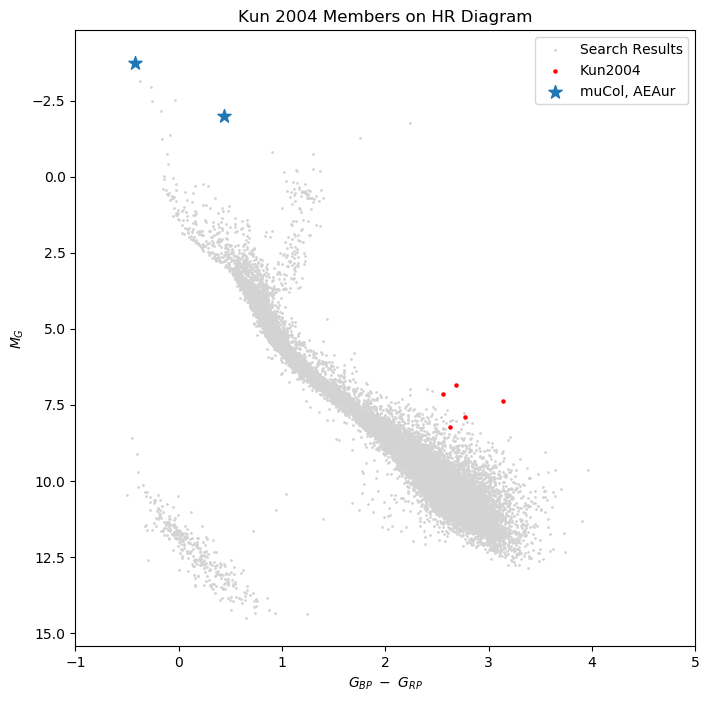

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
search_results1.plot_hrdiagram(ax=ax, s=1, color='lightgrey', label='Search Results')
ic2118_members.plot_hrdiagram(ax=ax, s=5, color='red',  label='Kun2004')
orion_runaways.plot_hrdiagram(ax=ax, s=100, marker='*', label='muCol, AEAur')
ax.set_title('Kun 2004 Members on HR Diagram')
ax.legend()

In [21]:
search_results=gs(name="conesearch near witch head nebula")
cons = ['{schema}.gaia_source.source_id is not NULL']
search_results.set_gaia_source_constraints(cons)

search_results.conesearch(cone_search_center[0]*u.degree, cone_search_center[1]*u.degree,search_radius*u.degree, parallax=(plx_lo, plx_hi))
len(search_results)

INFO: Query finished. [astroquery.utils.tap.core]


34838

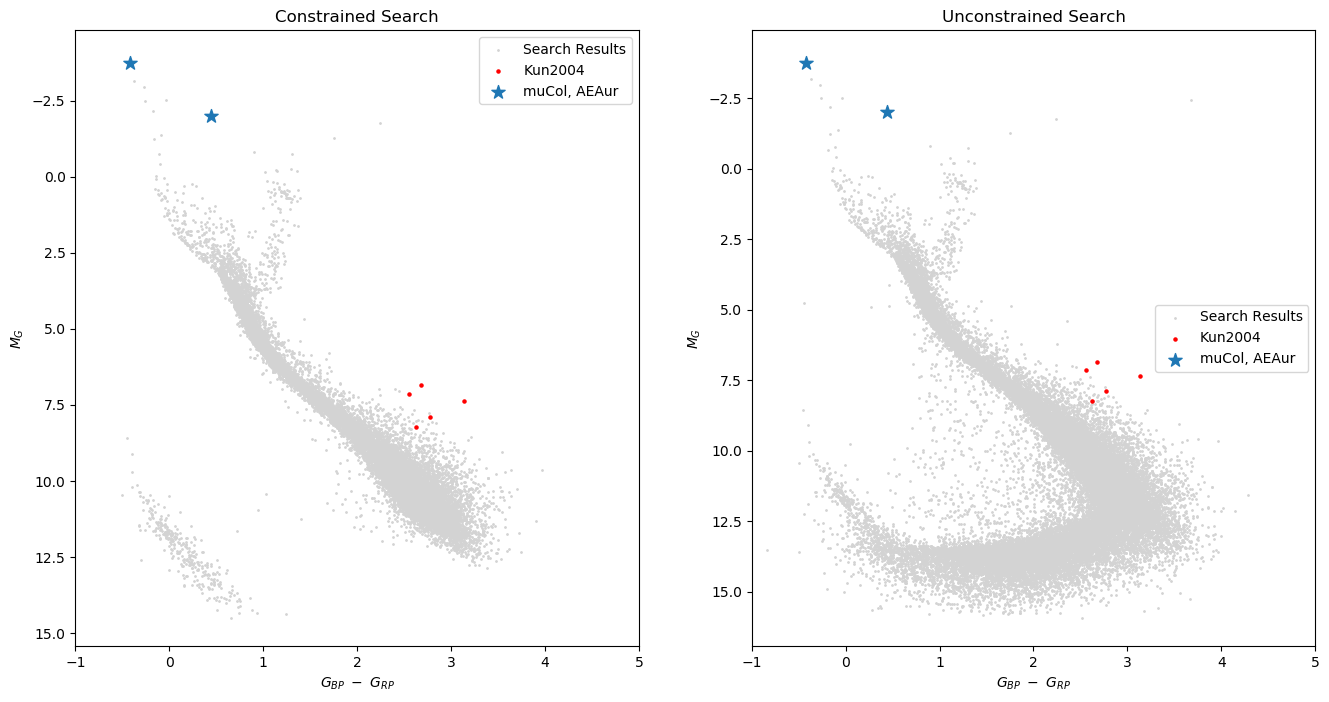

In [23]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)
search_results1.plot_hrdiagram(ax=ax[0], s=1, color='lightgrey', label='Search Results')
ic2118_members.plot_hrdiagram(ax=ax[0], s=5, color='red',  label='Kun2004')
orion_runaways.plot_hrdiagram(ax=ax[0], s=100, marker='*', label='muCol, AEAur')
ax[0].set_title('Constrained Search')
ax[0].legend()

search_results.plot_hrdiagram(ax=ax[1], s=1, color='lightgrey', label='Search Results')
ic2118_members.plot_hrdiagram(ax=ax[1], s=5, color='red', label='Kun2004')
orion_runaways.plot_hrdiagram(ax=ax[1], s=100, marker='*', label='muCol, AEAur')
ax[1].set_title('Unconstrained Search')
ax[1].legend()


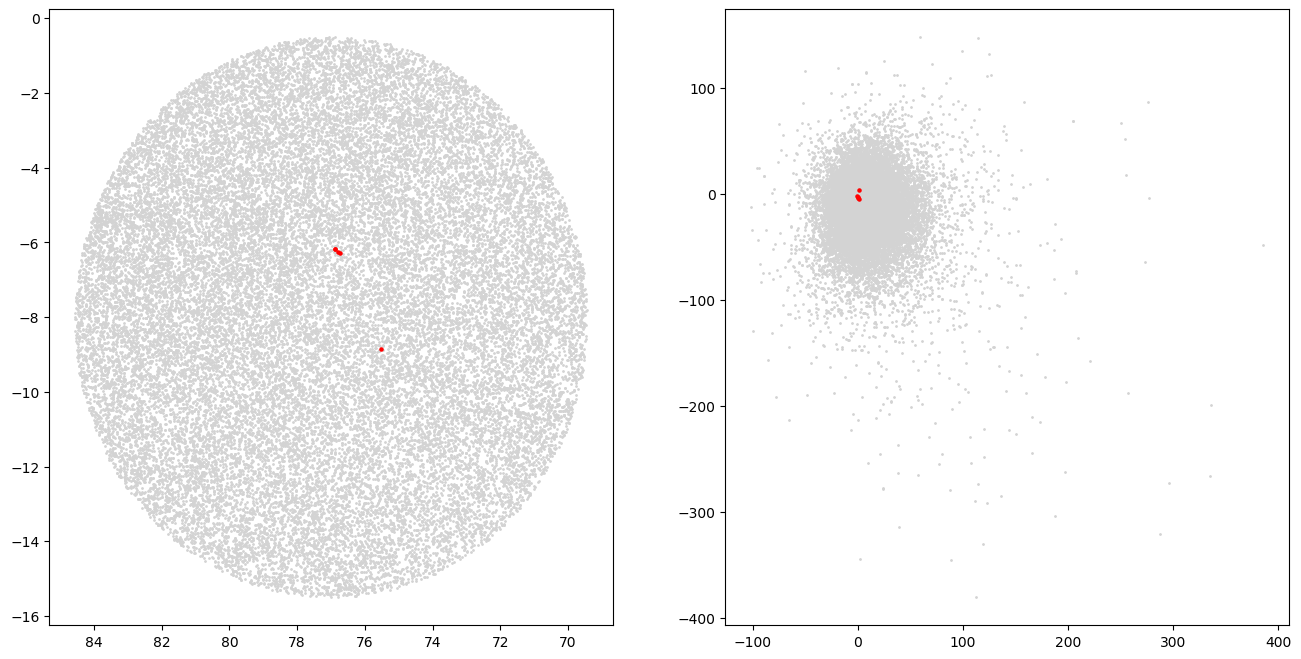

In [24]:
fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
axs[0].scatter(search_results.objs.ra, search_results.objs.dec, s=1, color='lightgrey')
axs[0].scatter(ic2118_members.objs.ra, ic2118_members.objs.dec, s=5, color='red')
axs[0].invert_xaxis()

axs[1].scatter(search_results.objs.pmra, search_results.objs.pmdec, s=1, color='lightgrey')
axs[1].scatter(ic2118_members.objs.pmra, ic2118_members.objs.pmdec, s=5, color='red')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
zz=ax.hist2d(search_results.objs.pmra, search_results.objs.pmdec,bins=300)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

## Just Results with Radial Velocity (for now)

In [ ]:
print(f"Search Results with RV: {np.isfinite(search_results.objs.radial_velocity).sum()}, total stars: {len(search_results)}")

In [ ]:
search_results.objs['hasRV'] = np.isfinite(search_results.objs.radial_velocity)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()

search_results.query('~hasRV').plot_hrdiagram(ax=ax, label='No Radial Velocity', color='grey')
search_results.query('hasRV').plot_hrdiagram(ax=ax, label='With Radial Velocity', color='red')

ax.set_title('Stars With and Without Radial Velocity')
ax.legend()

In [ ]:
search_results_rv = search_results.query('hasRV')

In [ ]:
rv_mean = search_results_rv.objs.radial_velocity.mean()
rv_sd = search_results_rv.objs.radial_velocity.std()
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()
ax.hist(search_results_rv.objs.radial_velocity, bins=50)
ax.axvline(rv_mean, lw=2, label=f'Mean: {rv_mean:.2f} km/s', color='red')
ax.axvline(rv_mean-rv_sd, ls=':', label=f'Std. Dev: {rv_sd:.2f} km/s', color='red')
ax.axvline(rv_mean+rv_sd, ls=':', color='red')
ax.legend()

In [ ]:
from transforms import pm_to_dxyz, spherical_to_cartesian, cartesian_to_spherical

In [ ]:
#cartesian motion in km/s
search_results_rv_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, s.radial_velocity)\
                                   for s in search_results_rv.objs.itertuples()]).T

In [ ]:
velocities = np.sqrt((search_results_rv_dxyz**2).sum(axis=0))

In [ ]:
vel_mean = velocities.mean()
vel_sd = velocities.std()
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()
ax.hist(velocities, bins=50)
ax.axvline(vel_mean, lw=2, label=f'Mean: {vel_mean:.2f} km/s', color='red')
ax.axvline(vel_mean-rv_sd, ls=':', label=f'Std. Dev: {vel_sd:.2f} km/s', color='red')
ax.axvline(vel_mean+rv_sd, ls=':', color='red')

ax.set_title('Distribution of Space Velocities')
ax.set_xlabel('Space Velocity (km/s)')
ax.set_ylabel('Number of Stars')

ax.legend()

In [ ]:
from astropy.coordinates import GalacticLSR
coords = search_results_rv.get_coords(recalc=True, default_rv=True)
coords_gal = coords.galactic
coords_gal_lsr = coords_gal.transform_to(GalacticLSR)

gal_dxyz = coords_gal.velocity.d_xyz
gal_dxyz_lsr = coords_gal_lsr.velocity.d_xyz


In [ ]:
(gal_dxyz_lsr - gal_dxyz).to_value()[:,:8]

In [ ]:
coords_gal[:10].pm_l_cosb

In [ ]:
coords_gal_lsr[:10].pm_l_cosb

## Compute Positions 10M Years Ago

In [ ]:
search_results_rv_dxyz.shape

```
def spherical_to_cartesian(ra, dec, r):
    alpha = np.radians(ra)
    delta = np.radians(dec)
    
    x = r * np.cos(delta)*np.cos(alpha)
    y = r * np.cos(delta)*np.sin(alpha)
    z = r * np.sin(delta)
    
    xyz = np.array([x, y, z])
    return xyz
   ```


In [ ]:
objs = search_results_rv.objs
search_results_rv_xyz = spherical_to_cartesian(objs.ra, objs.dec, objs.r_est)

#cartesian motion in km/s
search_results_rv_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, s.radial_velocity)\
                                   for s in objs.itertuples()]).T

look_back_time = -1.0*10e6 # years, negative for look BACK time

#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)

delta_xyz = search_results_rv_dxyz*look_back_time*seconds_per_year*pc_per_km
lbt_xyz = search_results_rv_xyz + delta_xyz



```
def cartesian_to_spherical(xyz):
    #xyz: one column for each star; one row for x, y and z
    r = np.sqrt((xyz**2).sum(axis=0))
    delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
    alpha = np.arctan2(xyz[1], xyz[0])
    alpha = np.where(alpha<0, alpha+2.0*np.pi, alpha)
    
    spherical = {'distance':r,
                 'alpha': np.rad2deg(alpha),
                 'delta': np.rad2deg(delta)
    }
    
    return spherical
```

In [ ]:
spherical = cartesian_to_spherical(lbt_xyz)

In [ ]:
spherical['alpha'][:10]

In [ ]:
spherical['delta'][:10]

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

ax.scatter(search_results.objs.ra, search_results.objs.dec, s=1, label='Search Results', color='lightgrey')

ax.scatter(orion_bright.RA_deg, orion_bright.Dec_deg,s=100, marker='+')
for s in orion_bright.itertuples():
    ax.annotate(s.Name,(s.RA_deg+offset, s.Dec_deg+offset))
    
ax.scatter(witchhead[0], witchhead[1], s=500,color='red', marker='*')
ax.annotate('Witchhead Nebula', (witchhead[0]+offset, witchhead[1]+offset))

ax.scatter(cone_search_center[0], cone_search_center[1], s=500, color='blue', marker='X')
ax.annotate('Search Center',(cone_search_center[0]+offset, cone_search_center[1]-6*offset),va='bottom')

ax.scatter(spherical['alpha'], spherical['delta'], color='red',label='previous position',s=2)

ax.invert_xaxis()
ax.grid(); ax.legend()
ax.set_aspect('equal')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

## Same Exercise Galactic LSR

In [ ]:
from astropy.coordinates import GalacticLSR
coords = search_results_rv.get_coords(recalc=True, default_rv=True)
coords_gal = coords.galactic
coords_gal_lsr = coords_gal.transform_to(GalacticLSR)

gal_lsr_xyz = coords_gal_lsr.cartesian.xyz.value
gal_lsr_dxyz = coords_gal_lsr.velocity.d_xyz.value


look_back_time = -1.0*10e6 # years, negative for look BACK time

#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)

delta_xyz = gal_lsr_dxyz*look_back_time*seconds_per_year*pc_per_km
lbt_xyz = gal_lsr_xyz + delta_xyz
gal_spherical = cartesian_to_spherical(lbt_xyz)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

ax.scatter(search_results.objs.ra, search_results.objs.dec, s=1, label='Search Results', color='lightgrey')

ax.scatter(orion_bright.RA_deg, orion_bright.Dec_deg,s=100, marker='+')
for s in orion_bright.itertuples():
    ax.annotate(s.Name,(s.RA_deg+offset, s.Dec_deg+offset))
    
ax.scatter(witchhead[0], witchhead[1], s=500,color='red', marker='*')
ax.annotate('Witchhead Nebula', (witchhead[0]+offset, witchhead[1]+offset))

ax.scatter(cone_search_center[0], cone_search_center[1], s=500, color='blue', marker='X')
ax.annotate('Search Center',(cone_search_center[0]+offset, cone_search_center[1]-6*offset),va='bottom')

ax.scatter(gal_spherical['alpha'], gal_spherical['delta'], color='red',label='previous position',s=2)

ax.invert_xaxis()
ax.grid(); ax.legend()
ax.set_aspect('equal')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

In [ ]:
fig = plt.figure(figsize=(18,8))
ax = fig.subplots(1,2)

zz=ax[0].hist2d(spherical['alpha'], spherical['delta'], bins=(90,45))
ax[0].invert_xaxis()

zz=ax[1].hist2d(gal_spherical['alpha'], gal_spherical['delta'], bins=(90,45))
ax[1].invert_xaxis()

In [ ]:
orion_stars = pd.DataFrame([
    dict(Name='M42', ra_hours='05h35m17.3s', dec_dms ='-05d23m28s', r_est = 412, pmra = 1.67, pmdec=-0.3, radial_velocity=27.8),
    dict(Name='Rigel', ra_hours="05h14m32.27210s", dec_dms ="-08d12m05.8981s", r_est=1000.0/3.78, pmra=1.31, pmdec=0.50, radial_velocity=17.8)
])
    
ra = Angle(orion_stars.ra_hours, unit='hour')
dec = Angle(orion_stars.dec_dms, unit='degree')

orion_stars['ra']= ra.to_value(u.degree)
orion_stars['dec'] = dec.to_value(u.degree)

orion_stars.set_index('Name', inplace=True)

orion_stars
    

In [ ]:

orion_stars_xyz = spherical_to_cartesian(orion_stars.ra, orion_stars.dec, orion_stars.r_est)

#cartesian motion in km/s
orion_stars_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, s.radial_velocity)\
                                   for s in orion_stars.itertuples()]).T


orion_delta_xyz = orion_stars_dxyz*look_back_time*seconds_per_year*pc_per_km
orion_lbt_xyz = orion_stars_xyz + orion_delta_xyz
orion_lbt_spherical = cartesian_to_spherical(orion_lbt_xyz)

In [ ]:
orion_lbt_spherical

In [ ]:
def plot_full_sky_contour(ra, dec, ax, gridsize=1):
    ra_rng = np.arange(0,360+gridsize, gridsize)
    dec_rng = np.arange(-90, 90+gridsize, gridsize)
    RA, DEC = np.meshgrid(ra_rng, dec_rng)
    star_counts = np.histogram2d(ra, dec, bins=(ra_rng, dec_rng))
    print(f"ra_rng shape: {ra_rng.shape}, dec_rng shape: {dec_rng.shape}")
    print(f'star_counts shape: {star_counts[0].shape}')
    pcm = ax.contourf(ra_rng[:-1], dec_rng[:-1], star_counts[0].T)
    if not ax.xaxis_inverted():
        ax.invert_xaxis()
    #ax.set_aspect('equal')
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    return (pcm)

In [ ]:
orion_lbt_spherical

In [ ]:
orion_stars

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(spherical['alpha'], spherical['delta'], ax, gridsize=5)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend()
fig.colorbar(pcm, label='Stars per 25 square degrees')

## Aside: Radial Velocity Experiment

What happens to a stars tragectory given a a fixed set of proper motions but varying radial velocities?

In [ ]:
def pos_lbt(init_xyz, d_xyz, lbts):
    #make sure everybody is a column vector
    assert init_xyz.shape==(3,1)
    assert d_xyz.shape==(3,1)
    
    seconds_per_year = (1.0*u.year).to_value(u.second)
    pc_per_km = (1.0*u.km).to_value(u.pc)
        
    delta_xyz = d_xyz.dot(lbts.reshape(1,-1)) * seconds_per_year * pc_per_km
    assert delta_xyz.shape == (3, len(lbts))
    
    return init_xyz + delta_xyz

In [ ]:
rv_vals = np.array([-10.0, -5.0, 0, 5.0, 10.0])
n_rv = len(rv_vals)
look_back_times = np.arange(-20e6, 10e4, 10e4)
#random star
star_i = 33
s = search_results.objs.iloc[star_i]

#go 3d
s_xyz = spherical_to_cartesian(s.ra, s.dec, s.dec).reshape(3,-1)
s_dxyz = pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv_vals)
#s_dxyz.shape is 3x rv_vals

#compute trajectory over the look back times for each rv
s_trajectory = np.array([pos_lbt(s_xyz, s_dxyz[:,[i]], look_back_times) for i in range(n_rv)])
#s_trajectory.shape = (n_rv, {x,y,z}, look_back_times)

trajectory_spherical = {}
for i in range(n_rv):
    trajectory_spherical[f'RV: {rv_vals[i]}'] = cartesian_to_spherical(s_trajectory[i])



In [ ]:
markers = list('+x1234')
#offset = 0.75
offset=0
lbt = -1.0*look_back_times.min()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='polar')
for i, (t, m) in enumerate(zip(trajectory_spherical, markers)):
    ax.plot(np.radians(trajectory_spherical[t]['alpha']), trajectory_spherical[t]['delta']+offset*i, label=t,marker=m,lw=1, ms=15)
               #c=look_back_times, cmap='gnuplot_r')
    
ax.set_ylabel('Declination (degree)')
ax.set_xlabel('Right Ascension (degree)')
ax.set_title(f'{lbt:.2e} Year Lookback Trajectories Given Varying Radial Velocities\nFixed Proper Motions')
ax.invert_xaxis()
ax.set_theta_zero_location("N")
ax.legend()

Plot above shows that the star follows same trajectory in \{RA, Dec\} space regardless of the radial velocity.  How fast a star gets to any given point on its trajectory is determined by its radial velocity.

## All Search Results

In [ ]:
objs = search_results.objs
search_results_xyz = spherical_to_cartesian(objs.ra, objs.dec, objs.r_est)

#cartesian motion in km/s; plug number for rv
search_results_dxyz = np.array([pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv_mean)\
                                   for s in objs.itertuples()]).T

look_back_time = -1.0*10e6 # years, negative for look BACK time

#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)

delta_xyz = search_results_dxyz*look_back_time*seconds_per_year*pc_per_km
lbt_xyz = search_results_xyz + delta_xyz

spherical = cartesian_to_spherical(lbt_xyz)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(spherical['alpha'], spherical['delta'], ax, gridsize=2)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend()
fig.colorbar(pcm, label='Stars per 4 square degree')

In [ ]:
#conversion factors
degree_per_mas = 1/(1000*60*60)
seconds_per_year = (1.0*u.year).to_value(u.second)
pc_per_km = (1.0*u.km).to_value(u.pc)
degree_per_mas, seconds_per_year, pc_per_km

In [ ]:
def get_pos_lbt(s, lbt, radial_velocity=0.0):
    
    #conversion factors:
    #import astropy.units as u
    #degree_per_mas = 1/(1000*60*60)
    #seconds_per_year = (1.0*u.year).to_value(u.second)
    #pc_per_km = (1.0*u.km).to_value(u.pc)
    
    degree_per_mas = 2.7777777777777776e-07
    seconds_per_year = 31557600.0
    pc_per_km = 3.240779289469756e-14
    
    s_xyz = spherical_to_cartesian(s.ra, s.dec, s.r_est).reshape(3,-1)
    
    rv = s.radial_velocity if np.isfinite(s.radial_velocity) else radial_velocity
    s_dxyz = pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv).reshape(3,1)
    delta_xyz = s_dxyz.dot( lbt.reshape(1,-1)) * seconds_per_year * pc_per_km
    
    pos = s_xyz + delta_xyz
    #print (pos, s_xyz, s_dxyz, delta_xyz)
    return pos  

## Orion Runaways

In [ ]:
len(np.linspace(-10e6,0,10001))

In [ ]:
#trajectories for ONC and two runaways
look_back_times = np.linspace(-10e6, 0, 10001)
trajectories = {}
xyz_onc = get_pos_lbt(ONC, look_back_times)
trajectories['ONC'] = {'trajectory':cartesian_to_spherical(xyz_onc),'look_back_time':None, 'min_dist':None, 'min_dist_i':0}


for ora in orion_runaways_gaiaedr3ids:
    trajectories[ora] = {}
    s = orion_runaways.objs.loc[orion_runaways_gaiaedr3ids[ora]]
    xyz = get_pos_lbt(s, look_back_times)
    trajectories[ora]['trajectory'] = cartesian_to_spherical(xyz)
    dist_onc = np.sqrt(((xyz-xyz_onc)**2).sum(axis=0))
    min_dist_i = dist_onc.argmin()
    trajectories[ora]['look_back_time']=look_back_times[min_dist_i]
    trajectories[ora]['min_dist'] = dist_onc[min_dist_i]
    trajectories[ora]['min_dist_i'] = min_dist_i
    
   

In [ ]:
for ora in orion_runaways_gaiaedr3ids:
    lbt_x = trajectories[ora]['look_back_time']
    min_dist = trajectories[ora]['min_dist']
    print(f'Star: {ora}, Min Dist: {min_dist:.2f} pc, look back time at min_dist: {lbt_x:.2e} years')

In [ ]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
i=10001
for ora,col in zip(orion_runaways_gaiaedr3ids, ['blue','orange']):
    min_dist_i = trajectories[ora]['min_dist_i']
    i = min(i, min_dist_i)
    traj = trajectories[ora]['trajectory']
    ax.scatter(traj['alpha'][min_dist_i:],traj['delta'][min_dist_i:], s=1,  label=ora, color=col)
    ax.scatter(traj['alpha'][-1],traj['delta'][-1], s=100, marker='*',color=col)

    
traj = trajectories['ONC']['trajectory']
ax.scatter(traj['alpha'][i:],traj['delta'][i:], s=1, label='ONC', color='green')
ax.scatter(traj['alpha'][-1],traj['delta'][-1], s=100, marker='*', color='green')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title('Current Position and Reverse Trajectories')
ax.legend()

ax.invert_xaxis()

NGC1980 relationship to ONC;

2012 Alves, Buoy Orion Revisited
look for group much futher in foreground distance= 200pc or less

grosschettle 2021

In [ ]:
i

In [ ]:
def get_pos_lbt_rv(s, lbt, ntrials, rv_mean, rv_sd):
    
    #conversion factors:
    #import astropy.units as u
    #degree_per_mas = 1/(1000*60*60)
    #seconds_per_year = (1.0*u.year).to_value(u.second)
    #pc_per_km = (1.0*u.km).to_value(u.pc)
    
    degree_per_mas = 2.7777777777777776e-07
    seconds_per_year = 31557600.0
    pc_per_km = 3.240779289469756e-14
    
    s_xyz = spherical_to_cartesian(s.ra, s.dec, s.r_est).reshape(3,-1)
    
    if np.isfinite(s.radial_velocity):
        rv = np.full(ntrials, s.radial_velocity)
    else:
        rv =  np.random.normal(rv_mean, rv_sd, ntrials)
        
    s_dxyz = pm_to_dxyz(s.ra, s.dec, s.r_est, s.pmra, s.pmdec, rv)
    delta_xyz = s_dxyz * lbt * seconds_per_year * pc_per_km
    
    pos = s_xyz + delta_xyz
    #print (pos, s_xyz, s_dxyz, delta_xyz)
    return pos  

In [ ]:
#mean and standard deviation for this population
f'rv_mean={rv_mean:.3f}, rv_sd={rv_sd:.3f}'

In [ ]:
xyz=get_pos_lbt_rv(search_results.objs.iloc[133], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
#xyz=get_pos_lbt_rv(orion_runaways.objs.iloc[1], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
xyz_s = cartesian_to_spherical(xyz)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(xyz_s['alpha'], xyz_s['delta'], ax, gridsize=2)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend(loc='lower left')

In [ ]:
def dist_lbt(star2, star1=None, lbt=-10e6,
                                maxpc=3, ntrials=10000, rv_mean=20.006, rv_sd=31.897):
    #presumably, star1 has full astrometry, incl radial_velocity
    #star2 full astrometry except radial_velocity
    
    pos1 = get_pos_lbt_rv(star1, lbt=lbt, ntrials=1, rv_mean=None, rv_sd=None)
    assert pos1.shape == (3,1)
    
    pos2 = get_pos_lbt_rv(star2, lbt=lbt, ntrials=ntrials, rv_mean=rv_mean, rv_sd=rv_sd)
    assert pos2.shape == (3, ntrials)
    
    #calc distances (broadcast pos1 across pos2)
    delta_xyz = pos2 - pos1
    distsq = (delta_xyz**2).sum(axis=0)
    assert distsq.shape == (ntrials,)
    dist = np.sqrt(distsq)
    
    n_within_thresh = (dist <= maxpc).sum()
    return n_within_thresh

In [ ]:
xyz=get_pos_lbt_rv(orion_stars.loc['M42'], -10e6, 1, rv_mean=20.006, rv_sd=31.897 )
xyz_s = cartesian_to_spherical(xyz)
xyz_s

In [ ]:
orion_lbt_spherical

In [ ]:
s = orion_stars.loc['M42']
spherical_to_cartesian(s.ra, s.dec, s.r_est)

In [ ]:
n  = dist_lbt( search_results.objs.iloc[28], star1=orion_stars.loc['M42'], ntrials=5)

In [ ]:
n

In [ ]:
xyz=get_pos_lbt_rv(orion_stars.loc['M42'], -10e6, 1, rv_mean=20.006, rv_sd=31.897 )
xyz

In [ ]:
get_pos_lbt_rv(orion_stars.loc['M42'], lbt=-10e6, ntrials=1, rv_mean=None, rv_sd=None)

In [ ]:
orion_stars.loc['M42']

In [ ]:
np.random.seed(1234)
encounters = search_results.objs.apply(dist_lbt,axis=1, star1= orion_stars.loc['Rigel'], maxpc=10)

In [ ]:
(encounters>0).sum()

In [ ]:
encounters[encounters>0]

In [ ]:
star_id = 3210820346789796352                
xyz=get_pos_lbt_rv(search_results.objs.loc[star_id], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
#xyz=get_pos_lbt_rv(orion_runaways.objs.iloc[1], -10e6, 10000, rv_mean=20.006, rv_sd=31.897 )
xyz_s = cartesian_to_spherical(xyz)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

pcm = plot_full_sky_contour(xyz_s['alpha'], xyz_s['delta'], ax, gridsize=2)
for i, (s, c) in enumerate(zip(orion_stars.index, ['orange','white'])):
    ax.scatter(orion_stars.loc[s].ra, orion_stars.loc[s].dec, marker='*', s=50,color=c,label=f'{s} Current Position')
    ax.scatter(orion_lbt_spherical['alpha'][i], orion_lbt_spherical['delta'][i], marker="+",s=50, color=c, label=f'{s} LBT Position')
ax.legend(loc='lower left')

In [ ]:
orion_stars.loc['Rigel']